# Monitoring and Anomaly Detection - Developing Prediction Model

## Group 32 - Michael Beiene - mb8726 ||  Jose Mayor - jam9942

## Introduction

For our culminating project in the Mobile Security course, we delved into exploring various strategies to bolster the security of mobile payment systems. A pivotal component of our strategy is the "Monitoring and Anomaly Detection" measure. To operationalize this, we have developed a predictive model specifically tailored to continuously oversee mobile payment activities and pinpoint any anomalies, ensuring a more secure transaction environment.

We are going to create three models using Decision Tree classifier, Random Forest classifier, and GBT classifier algorithm. We are going to choose the algorithm that performs better.

## Data

The data used in this project is synthetic financial datasets for fraud detection that is  obtained from Kaggle. 
The data can be accessed by going to this link https://www.kaggle.com/datasets/ealaxi/paysim1 


The dataset has the following fields

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount - amount of the transaction in local currency.
- nameOrig - customer who started the transaction
- oldbalanceOrg - initial balance before the transaction
- newbalanceOrig - new balance after the transaction.
- nameDest - customer who is the recipient of the transaction
- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [174]:
# Project - Prediction Model to determine if mobile payment is fraud
# Description - This project is part of final Project for Mobile Security class at NYU for Group 32
# Version 1.0
# Aug 8, 2023
##############################################################################################
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, sum as sql_sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier,DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#Creating a Spark session

spark = SparkSession.builder \
    .appName("Mobile Payment Security") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()

In [175]:
#Read the CSV file

data = spark.read.csv('F:\\learn\\NYU\\mobile_security\\paysim.csv', header=True, inferSchema=True)


In [176]:
# check the first 25 records of the dataset
data.show(25)


+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [177]:
#Check the detail schema of the dataset
data.printSchema()


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [178]:
# Create and show a DataFrame with the count of null values for each column. We do this since most columns are nullable
null_counts = data.select([sql_sum(col(c).isNull().cast('int')).alias(c) for c in data.columns])
null_counts.show()


+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



## Data Analysis

The dataset has an indicator weather transaction is fraud or not. We labeled the datasets as 'safe' or 'fraud'


Within the transaction data, our objective is to determine the financial impact of fraudulent activities to gauge the magnitude of the issue. Based on our findings, there are 287 transactions, totaling $10 million, that have been identified as fraudulent.

In [180]:
# Filter fraud transactions
fraud_transactions = data.filter(col('isFraud') == 1)

# Group by the 'amount' column and count occurrences
fraud_amount_counts = fraud_transactions.groupBy('amount').agg(count('amount').alias('count'))

# Format the 'amount' column to full decimal representation
fraud_amount_counts = fraud_amount_counts.withColumn('amount', format_number('amount', 0))

# Order by count in descending order
fraud_amount_counts = fraud_amount_counts.orderBy('count', ascending=False)

# Show the result
fraud_amount_counts.show()


+----------+-----+
|    amount|count|
+----------+-----+
|10,000,000|  287|
|         0|   16|
| 1,165,188|    4|
|   429,257|    4|
|   262,435|    2|
| 6,188,515|    2|
|   121,627|    2|
|   307,739|    2|
| 1,102,134|    2|
|   120,075|    2|
|   696,763|    2|
|    12,461|    2|
|   143,032|    2|
|    11,308|    2|
|     9,217|    2|
| 1,639,676|    2|
|    22,877|    2|
| 2,066,468|    2|
|   164,501|    2|
|    20,128|    2|
+----------+-----+
only showing top 20 rows



To further assess the repercussions of fraudulent activities, we can examine both the quantity of such transactions and the associated monetary values. Our analysis reveals that there are eight thousand fraudulent transactions, each ranging between 1001 dollars and 5000 dollars in value.

Both analyses highlight that fraudulent transactions pose a significant issue with substantial consequences, necessitating immediate attention and resolution.

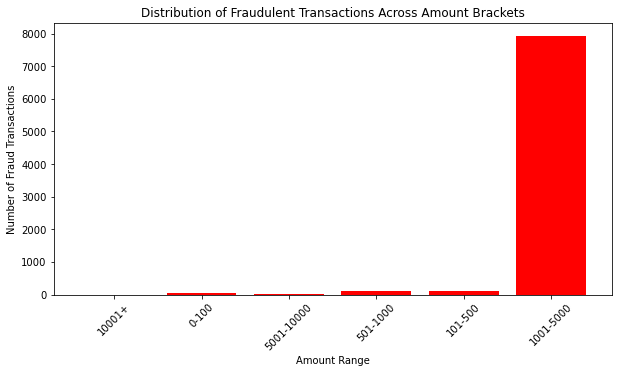

In [190]:
# Filter fraud transactions and exclude those with an amount of zero
fraud = data.filter((col('isFraud') == 1) & (col('amount') > 0))

# Define the splits for the bucketing
splits = [0, 100, 500, 1000, 5000, 10000, float('inf')]

# Create the bucketizer
bucketizer = Bucketizer(splits=splits, inputCol="amount", outputCol="amount_range")

# Transform the original data into its bucket index
fraud_with_buckets = bucketizer.transform(fraud)

# Group by the buckets and count the transactions in each
fraud_counts_by_bucket = fraud_with_buckets.groupBy('amount_range').agg(count('amount').alias('count'))

# Convert to Pandas DataFrame for visualization
fraud_counts_pd = fraud_counts_by_bucket.toPandas()

# Labels for the x-axis (representing the ranges)
labels = ["0-100", "101-500", "501-1000", "1001-5000", "5001-10000", "10001+"]

# Plotting the count of fraud transactions by amount range
plt.figure(figsize=(10, 5))
plt.bar(fraud_counts_pd['amount_range'], fraud_counts_pd['count'], color='red', tick_label=labels)
plt.xlabel('Amount Range')
plt.ylabel('Number of Fraud Transactions')
plt.title('Distribution of Fraudulent Transactions Across Amount Brackets')
plt.xticks(rotation=45)
plt.show()


In our subsequent analysis, we sought to understand the distribution of safe versus fraudulent transactions throughout the month. Our findings revealed that safe transactions peak during the first 15 days and taper off in the latter half of the month. Conversely, fraudulent transactions maintain a consistent frequency for most of the month, with only slight decreases at the beginning and end.

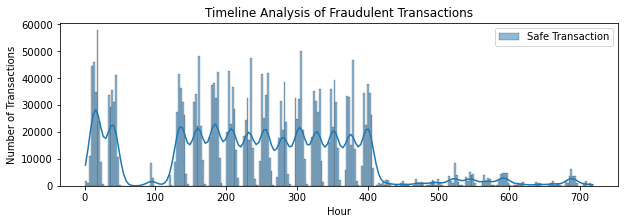

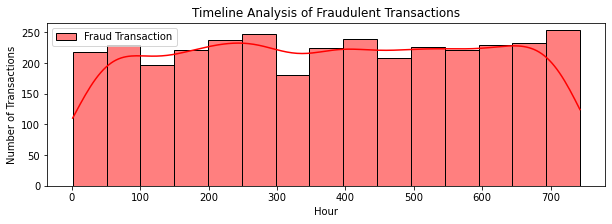

In [191]:

# Filter data by the labels. Safe and Fraud transaction
safe = data.filter(col('isFraud') == 0)
fraud = data.filter(col('isFraud') == 1)

# Sample a fraction of the data to avoid memory issues (e.g., 10%)
sample_fraction = 0.4
safe_sample = safe.sample(False, sample_fraction, seed=42)
fraud_sample = fraud.sample(False, sample_fraction, seed=42)

# Convert to Pandas DataFrame for visualization
safe_pd = safe_sample.toPandas()
fraud_pd = fraud_sample.toPandas()

# Plot safe transactions
plt.figure(figsize=(10, 3))
sns.histplot(safe_pd['step'], kde=True, label="Safe Transaction")  # Histogram with KDE
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Timeline Analysis of Fraudulent Transactions')
plt.legend()
plt.show()

# Plot fraud transactions
plt.figure(figsize=(10, 3))
sns.histplot(fraud_pd['step'], kde=True, color='red', label='Fraud Transaction')  # Histogram with KDE, red color
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Timeline Analysis of Fraudulent Transactions')
plt.legend()
plt.show()


To delve deeper into the distribution of fraudulent transactions over the month, we conducted an extensive analysis. Our findings suggest that the fraudulent transactions don't follow a distinct pattern across the month. However, it's noteworthy that there is a significant spike in such transactions around the middle of the month compared to other days.

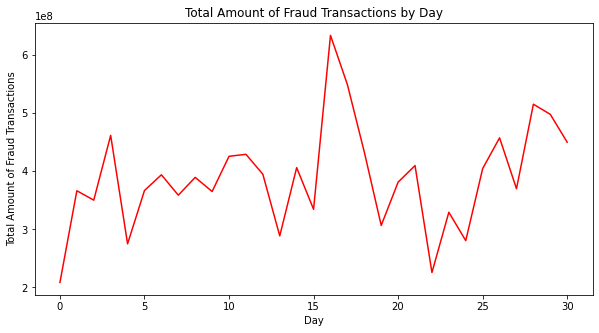

In [181]:
# Filter fraud transactions
fraud = data.filter((col('isFraud') == 1) & (col('amount') > 0))

# Calculate the day from the 'step' column (assuming step is in hours)
fraud_with_day = fraud.withColumn('day', floor(col('step') / 24))

# Group by day and sum the amounts for each day
fraud_amounts_by_day = fraud_with_day.groupBy('day').agg(sum('amount').alias('total_amount')).orderBy('day')

# Convert to Pandas DataFrame for visualization
fraud_amounts_pd = fraud_amounts_by_day.toPandas()

# Plotting the total fraud transactions by day
plt.figure(figsize=(10, 5))
plt.plot(fraud_amounts_pd['day'], fraud_amounts_pd['total_amount'], color='red')
plt.xlabel('Day')
plt.ylabel('Total Amount of Fraud Transactions')
plt.title('Total Amount of Fraud Transactions by Day')
plt.show()


In a comparison between safe and fraudulent transactions, a vast majority at 99.9% are legitimate, while a mere 0.1% are fraudulent. While the proportion of fraudulent transactions might appear minimal in comparison to legitimate ones, their financial repercussions, as highlighted in our previous analysis, are disproportionately significant.

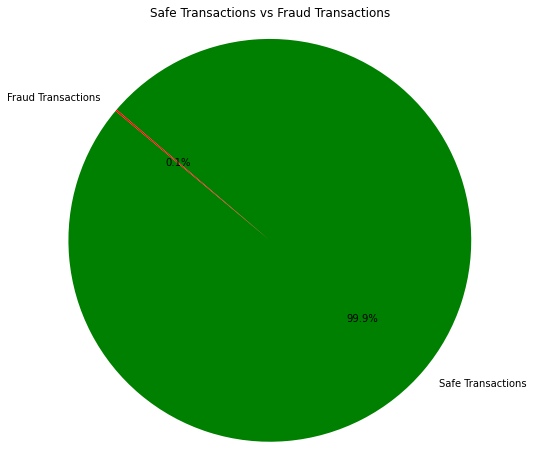

In [192]:
# Filter transactions into safe and fraud categories
safe_transactions_count = data.filter(col('isFraud') == 0).count()
fraud_transactions_count = data.filter(col('isFraud') == 1).count()

# Data for the pie chart
counts = [safe_transactions_count, fraud_transactions_count]
labels = ['Safe Transactions', 'Fraud Transactions']
colors = ['green', 'red']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Safe Transactions vs Fraud Transactions')
plt.show()


In our concluding analysis of the dataset, we aimed to pinpoint which transaction types are most susceptible to fraudulent activity. We found that the transaction types 'Cash out' and 'Transfer' are the most prone to fraud. Breaking down the fraudulent activities, 'Cash out' transactions make up 50.1%, while 'Transfer' transactions account for 49.9%.

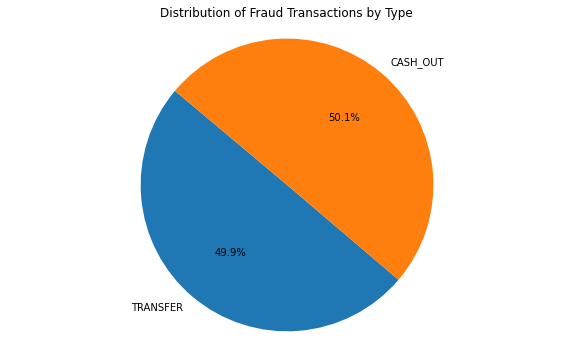

In [162]:
# Filter fraud transactions
fraud_transactions = data.filter(col('isFraud') == 1)

# Group by the type of transaction and count the occurrences of each type
fraud_transactions_by_type = fraud_transactions.groupBy('type').agg(count('type').alias('count')).toPandas()

# Extracting counts and labels for the pie chart
counts = fraud_transactions_by_type['count']
labels = fraud_transactions_by_type['type']

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Fraud Transactions by Type')
plt.show()


## Feature Engineering

In our feature engineering process, we focused on the transaction types 'Cash out' and 'Transfer', as they have been identified as the most susceptible to fraudulent activities.

In [183]:
# Filtering only 'TRANSFER' and 'CASH_OUT' data
data_by_type = data.filter(col('type').isin(['TRANSFER', 'CASH_OUT']))


In [184]:
df = df.withColumn("index", monotonically_increasing_id())
df = df.orderBy("index")


In [185]:
# Drop the name columns
df = df.drop('nameOrig', 'nameDest')

# Binary-encoding of labelled data in 'type'
df = df.withColumn('type', when(col('type') == 'CASH_OUT', 1).when(col('type') == 'TRANSFER', 0).otherwise(col('type')))



## Machine Learning

In the machine learning segment of our project, we will evaluate and compare three distinct algorithms: Decision Tree, Random Forest, and Gradient Boosted Trees (GBT).

In [186]:
# Explicitly casting 'type' column to integer
df = df.withColumn('type', col('type').cast(IntegerType()))

# Assuming 'isFraud' is the target and all other columns are features
feature_columns = [col_name for col_name in df.columns if col_name != 'isFraud']

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df).select(col("features"), col("isFraud").alias("label"))

# Split the data into train and test (80% training, 20% testing)
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=42)



In [187]:
algorithms = [DecisionTreeClassifier, RandomForestClassifier, GBTClassifier]


In [188]:
# Function to run classifier with default parameters to get baseline model
def ml_func(algorithm, train_data, test_data):
    # Create model
    model = algorithm()

    # Define a pipeline
    pipeline = Pipeline(stages=[model])

    # Fit the model
    fitted_model = pipeline.fit(train_data)

    # Make predictions
    train_preds = fitted_model.transform(train_data)
    test_preds = fitted_model.transform(test_data)

    # Evaluate
    evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
    train_accuracy = evaluator.evaluate(train_preds)
    test_accuracy = evaluator.evaluate(test_preds)

    print(str(algorithm))
    print("------------------------")
    print(f"Training AUC: {(train_accuracy * 100):.4}%")
    print(f"Test AUC:     {(test_accuracy * 100):.4}%")
    
    # You can further store the results as required


In [189]:
# Running each model and printing accuracy scores
for algorithm in algorithms:
    ml_func(algorithm, train_data, test_data)

<class 'pyspark.ml.classification.DecisionTreeClassifier'>
------------------------
Training AUC: 54.11%
Test AUC:     56.68%
<class 'pyspark.ml.classification.RandomForestClassifier'>
------------------------
Training AUC: 96.52%
Test AUC:     96.48%
<class 'pyspark.ml.classification.GBTClassifier'>
------------------------
Training AUC: 99.45%
Test AUC:     99.13%


Based on the results presented in the preceding report, the Gradient Boosted Trees (GBT) algorithm surpasses both the Decision Tree and Random Forest in performance. Hence, we have decided to employ the GBT algorithm for our final implementation.

## Conclusion

From our implementation, it's evident that machine learning can be harnessed for monitoring and anomaly detection, significantly bolstering the security aspect of mobile payments. The Gradient Boosted Trees (GBT) algorithm, in particular, has demonstrated superior performance when compared to both Decision Tree and Random Forest. To further enhance the accuracy of our model, there's potential in optimizing the model by balancing the dataset.